In [2]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.linear_model import LinearRegression
import tensorflow as tf

In [5]:
weather_data = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('../data/Plant_1_Generation_Data.csv')
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['Time'] = weather_data.DATE_TIME.dt.time
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'])
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))
X= merged_df.loc[:, ['DC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
X_scaled = MinMaxScaler().fit_transform(X)
X_scaled

array([[0.        , 0.32219047, 0.09950559, 0.        ],
       [0.        , 0.32219047, 0.09950559, 0.        ],
       [0.        , 0.32219047, 0.09950559, 0.        ],
       ...,
       [0.        , 0.10170895, 0.0482553 , 0.        ],
       [0.        , 0.10170895, 0.0482553 , 0.        ],
       [0.        , 0.10170895, 0.0482553 , 0.        ]])

In [63]:
X.shape[1]

4

In [6]:
# input_layer = Input(shape =(X.shape[1], ))
input_layer = Input(shape =(4,))

# encoded = Dense(100, activation ='tanh',activity_regularizer = regularizers.l1(10e-5))(input_layer)
# encoded = Dense(75, activation ='tanh',activity_regularizer = regularizers.l1(10e-5))(encoded)
# encoded = Dense(50, activation ='tanh',activity_regularizer = regularizers.l1(10e-5))(encoded)
# encoded = Dense(25, activation ='tanh',activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(4, activation ='tanh',activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoded = Dense(2, activation ='tanh')(encoded)

decoded = Dense(4, activation ='tanh')(encoded)
# decoded = Dense(25, activation ='tanh')(decoded)
# decoded = Dense(50, activation ='tanh')(decoded)
# decoded = Dense(75, activation ='tanh')(decoded)
# decoded = Dense(100, activation ='tanh')(decoded)

output_layer = Dense(X.shape[1], activation ='sigmoid')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer ="adam", loss ="mse")

In [7]:
History=autoencoder.fit(X_scaled, X_scaled,batch_size = 500, epochs = 100,shuffle = True, validation_split = 0.10)

Epoch 1/100
124/124 [==============================] - 2s 4ms/step - loss: 0.1136 - val_loss: 0.0734
Epoch 2/100
124/124 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0295
Epoch 3/100
124/124 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0122
Epoch 4/100
124/124 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0072
Epoch 5/100
124/124 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0052
Epoch 6/100
124/124 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0042
Epoch 7/100
124/124 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 8/100
124/124 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 9/100
124/124 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 10/100
124/124 [==============================] - 0s 2ms/step - loss: 0.0037 - val_lo

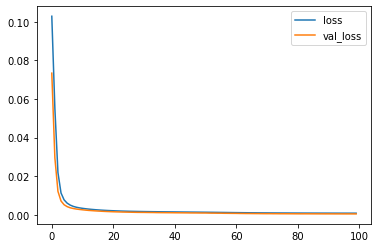

In [8]:
plt.plot(History.history['loss'], label='loss')
plt.plot(History.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [9]:
encoded_train_data=autoencoder.predict(X_scaled)
decoded_train_data=autoencoder.predict(encoded_train_data)
# decoded_train_data

In [10]:
scaled_train_features = pd.DataFrame(encoded_train_data, index=X.index, columns=X.columns)
X_scaled_df=pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
train_mae_loss = np.mean((X_scaled_df - scaled_train_features)**2, axis=1)
# train_mae_loss

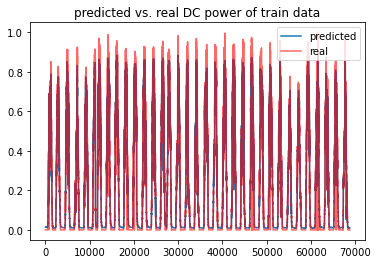

In [11]:
# plt.figure(figsize=(15, 10))
plt.plot(scaled_train_features.DC_POWER, label='predicted')
plt.plot(X_scaled_df.DC_POWER, label='real', color='r', alpha=0.6)
plt.title('predicted vs. real DC power of train data')
plt.legend()
plt.show()

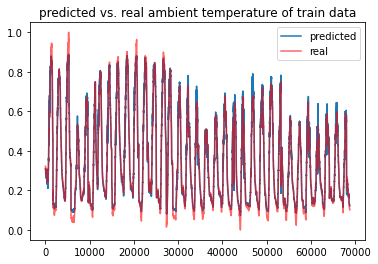

In [12]:
# plt.figure(figsize=(15, 10))
plt.plot(scaled_train_features.AMBIENT_TEMPERATURE, label='predicted')
plt.plot(X_scaled_df.AMBIENT_TEMPERATURE, label='real', color='r', alpha=0.6)
plt.title('predicted vs. real ambient temperature of train data')
plt.legend()
plt.show()

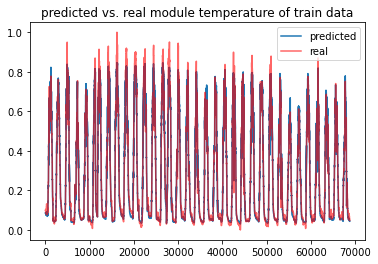

In [13]:
# plt.figure(figsize=(15, 10))
plt.plot(scaled_train_features.MODULE_TEMPERATURE, label='predicted')
plt.plot(X_scaled_df.MODULE_TEMPERATURE, label='real', color='r', alpha=0.6)
plt.title('predicted vs. real module temperature of train data')
plt.legend()
plt.show()

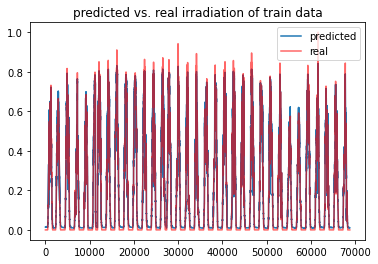

In [14]:
# plt.figure(figsize=(15, 10))
plt.plot(scaled_train_features.IRRADIATION, label='predicted')
plt.plot(X_scaled_df.IRRADIATION, label='real', color='r', alpha=0.6)
plt.title('predicted vs. real irradiation of train data')
plt.legend()
plt.show()

In [15]:
merged_err=merged_df.join(pd.DataFrame(train_mae_loss))
merged_err.rename(columns={0: 'ERROR'}, inplace=True)
# merged_err.head()

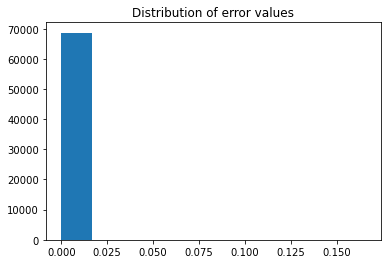

In [16]:
plt.hist(merged_err['ERROR'])
plt.title('Distribution of error values')
plt.show()

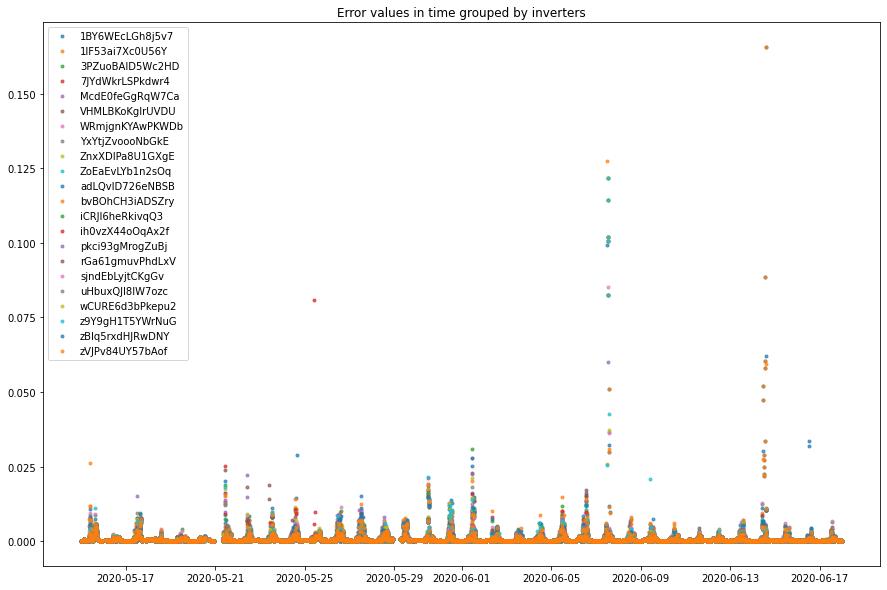

In [17]:
plt.figure(figsize=(15, 10))
for i, inv in merged_err.groupby(merged_err.SOURCE_KEY):
    plt.plot_date(inv.DATE_TIME, inv.ERROR,'.', label=i, alpha=0.7)
#     plt.show()
plt.legend()
plt.title('Error values in time grouped by inverters')
plt.show()

In [18]:
def get_outliers_for_fit(data, x_column, y_column, groupby_column, output_column_name=False, window=False, outlier_limit=3):
    if output_column_name==False:
        output_column_name=column+"_outliers"
    data[output_column_name]=0
    data['gross_efficiency']=data[y_column]/data[x_column]
    for i, group in  data.groupby(groupby_column):
        resorted=group.reset_index().set_index('DATE_TIME').copy()
        outlier_condition1=resorted[resorted[y_column]>0]['gross_efficiency']>(resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).mean() + (outlier_limit+1)*resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).std())
        outlier_condition2=resorted[resorted[y_column]>0]['gross_efficiency']<(resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).mean() - outlier_limit*resorted[resorted[y_column]>0]['gross_efficiency'].rolling(window=window).std())            
        outlier_condition3=resorted[resorted[y_column]>0][x_column]>0.1*resorted[resorted[y_column]>0][x_column].rolling(window=window).max()
        data.loc[resorted[resorted[y_column]>0][(outlier_condition1|outlier_condition2)&outlier_condition3]['index'], output_column_name]=1
        data.loc[resorted[(resorted[y_column]==0)&(resorted[x_column]>0.1*resorted[x_column].rolling(window=window).max())]['index'], output_column_name]=1
    return data
def get_outlier_errors(data, column, groupby_column, output_column_name=False, outlier_limit=3, window='7d'):
    #cleaned_column='cleaned'
    if output_column_name==False:
        output_column_name=column+"_outliers"
    data[output_column_name]=0
    resorted=data.reset_index().set_index('DATE_TIME').copy()
    outlier_condition1=resorted[resorted[column]>0][column]>(resorted[resorted[column]>0][column].rolling(window=window).mean() + (outlier_limit)*resorted[resorted[column]>0][column].rolling(window=window).std())
    data.loc[resorted[resorted[column]>0][outlier_condition1]['index'], output_column_name]=1
    return data

In [21]:
merged_outliers=get_outlier_errors(merged_err, 'ERROR', 'SOURCE_KEY', output_column_name="alarm_DC_conversion_outlier", window='7d', outlier_limit=8)

In [22]:
merged_dc_outlier=get_outliers_for_fit(merged_outliers.copy(), 'IRRADIATION', 'DC_POWER', 'SOURCE_KEY', output_column_name="alarm_DC_conversion_outlier_targ", window='7d', outlier_limit=4)

In [23]:
# def get_outliers_by_residual(data, x_column, y_column, output_column_name="residual_outliers", anomaly_limit=5):
#     data[output_column_name]=0
#     for i in data.SOURCE_KEY.unique():
#         inv_data=data[data.SOURCE_KEY==i]
#         for a, day in inv_data.groupby(inv_data.DAY):
#             X = data[x_column].values.reshape(-1,1)
#             y = data[y_column].values.reshape(-1,1)
#             regressor = LinearRegression(fit_intercept=False)
#             regressor.fit(X, y)
#             m=regressor.coef_[0]
#             residual=(day[y_column]-m*day[x_column])**2 # or we can take the absolute value
#             mean_res = residual.mean()
#             stand_dev = residual.std()
#             data.loc[day[(residual>mean_res+anomaly_limit*stand_dev) | (residual<mean_res-anomaly_limit*stand_dev)].index, output_column_name] = 1
#     return data

In [24]:
# merged_ac_conv_out=get_outliers_by_residual(merged_dc_outlier, 'DC_POWER', 'AC_POWER',output_column_name="alarm_AC_conversion_outlier", anomaly_limit=5)

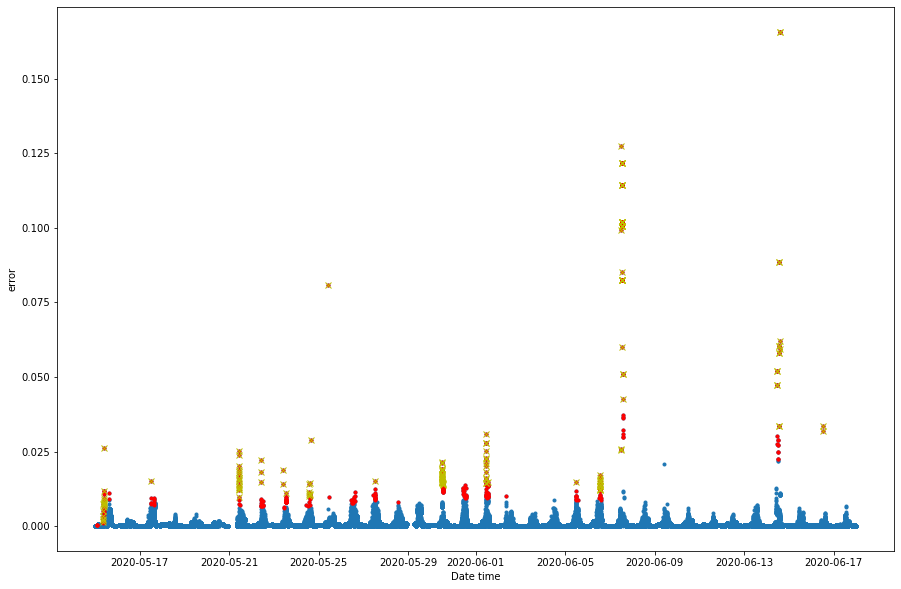

In [25]:
plt.figure(figsize=(15, 10))
plt.plot(merged_dc_outlier['DATE_TIME'], merged_dc_outlier['ERROR'], '.')
plt.plot(merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier"]==1]['DATE_TIME'], 
         merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier"]==1]['ERROR'], 'r.')
plt.plot(merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier_targ"]==1]['DATE_TIME'], 
         merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier_targ"]==1]['ERROR'], 'yx')
# plt.plot(merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['DATE_TIME'], 
#          merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['ERROR'], 'gx')
plt.xlabel('Date time')
plt.ylabel('error')
plt.show()

###### We can see that the high error rates are mainly caused by the errors that happen during Irradiation to DC and DC to AC conversions.

## 2. Inverter level efficiency
#### a) Take the mean of the reconstruction error for each inverter after removing the outliers

In [26]:
print(merged_outliers[merged_outliers.alarm_error_outlier == 1].shape)
clean_data=merged_outliers.copy()
print(clean_data.shape)
clean_data.drop(clean_data.loc[clean_data.alarm_error_outlier == 1].index, inplace=True)
print(clean_data.shape)  

(372, 19)
(68774, 19)
(68402, 19)


In [27]:
def inverter_error(data):
    mean_error=[]
    inverters=[]
    for i, inv in data.groupby(data.SOURCE_KEY):
        ind = inv[inv['SOURCE_KEY']==i].index.values
        m = inv.ERROR.mean()
        mean_error.append(m)
        inverters.append(i)
    inv_error_df = pd.DataFrame(data=np.array(mean_error), columns=['MEAN_ERROR'])
    source_key = pd.DataFrame(data=np.array(inverters), columns=['SOURCE_KEY'])
    inv_error_df['SOURCE_KEY'] = source_key['SOURCE_KEY']
    return(inv_error_df)

In [28]:
inv_error_df=inverter_error(clean_data)
# inv_error_df.head()

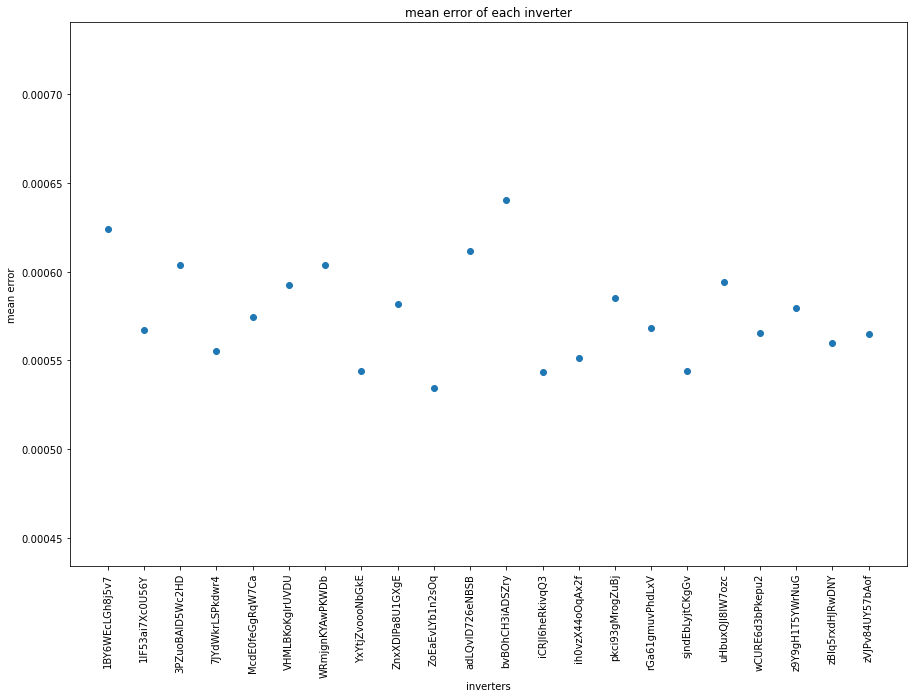

In [29]:
plt.figure(figsize=(15, 10))
plt.scatter(inv_error_df.SOURCE_KEY,inv_error_df.MEAN_ERROR)
plt.xticks(rotation=90) 
plt.ylim(inv_error_df.MEAN_ERROR.min()-0.0001,inv_error_df.MEAN_ERROR.max()+0.0001)
plt.xlabel('inverters')
plt.ylabel('mean error')
plt.title('mean error of each inverter')
plt.show()

#### b) Calculate a mean reconstruction error per inverter per day and then compare those mean values to find inverters with higher mean reconstruction error in a single day and then over several days.

In [30]:
def daily_inverter_error(data):
    mean_error=[]
    inverters=[]
    days=[]
    for a, day in data.groupby(data.DAY):
        for i, inv in day.groupby(day.SOURCE_KEY):
            ind = inv[inv['SOURCE_KEY']==i].index.values
            m = inv.ERROR.mean()
            mean_error.append(m)
            inverters.append(i)
            days.append(a)
    inv_error_df = pd.DataFrame(data=np.array(mean_error), columns=['MEAN_ERROR'])
    source_key = pd.DataFrame(data=np.array(inverters), columns=['SOURCE_KEY'])
    Days = pd.DataFrame(data=np.array(days), columns=['DAY'])
    inv_error_df['SOURCE_KEY'] = source_key['SOURCE_KEY']
    inv_error_df['DAY']=Days['DAY']
    return(inv_error_df)

In [31]:
daily_inv_error_df=daily_inverter_error(clean_data)
# daily_inv_error_df

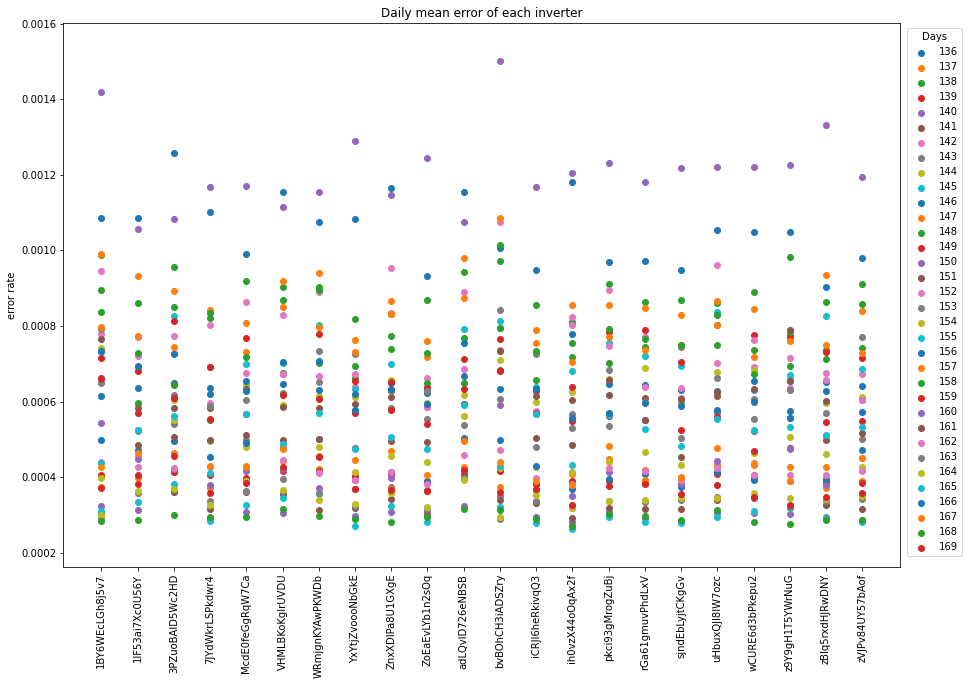

In [32]:
plt.figure(figsize=(15, 10))
for i, day in daily_inv_error_df.groupby(daily_inv_error_df.DAY):
    plt.scatter(day.SOURCE_KEY, day.MEAN_ERROR, label=i)
plt.xticks(rotation=90)
plt.ylim(daily_inv_error_df.MEAN_ERROR.min()-0.0001,daily_inv_error_df.MEAN_ERROR.max()+0.0001)
plt.ylabel('error rate')
plt.legend(loc="upper right", title="Days", bbox_to_anchor=(1.08, 1))
plt.title('Daily mean error of each inverter')
plt.show()

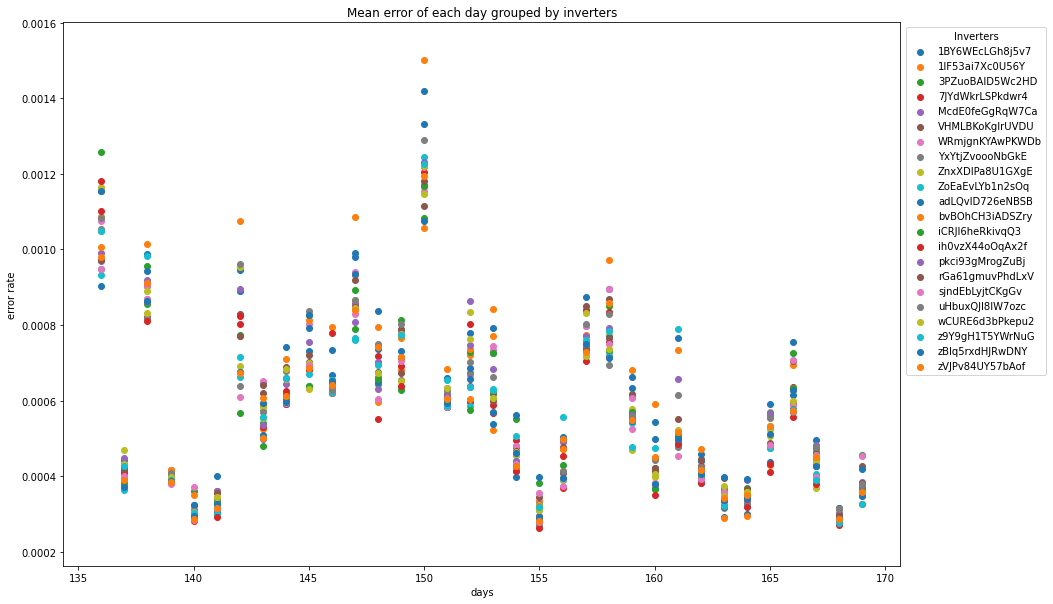

In [33]:
plt.figure(figsize=(15, 10))
for i, inv in daily_inv_error_df.groupby(daily_inv_error_df.SOURCE_KEY):
    plt.scatter(inv.DAY, inv.MEAN_ERROR, label=i)
plt.ylim(daily_inv_error_df.MEAN_ERROR.min()-0.0001,daily_inv_error_df.MEAN_ERROR.max()+0.0001)
plt.ylabel('error rate')
plt.xlabel('days')
plt.legend(loc="upper right", title="Inverters", bbox_to_anchor=(1.18, 1))
plt.title('Mean error of each day grouped by inverters')
plt.show()

In [34]:
def get_inefficient_inverters_day(data, column, output_column_name, anomaly_limit = 2):
    data[output_column_name] = 0
    for _,d in data.groupby('DAY'):
        col_mean = d[column].mean()
        col_std = d[column].std()
        data.loc[d[(d[column] > col_mean + anomaly_limit * col_std)].index,output_column_name] = 1
    return data
def get_inefficient_inverters_window(data, column, output_column_name, window=7):
    data[output_column_name] = 0
    for inv in data['SOURCE_KEY'].unique():
        data.loc[data['SOURCE_KEY']==inv, output_column_name]=data[data['SOURCE_KEY']==inv][column].rolling(window = window).min()
    return data

Text(0, 0.5, 'DC conversion coefficient')

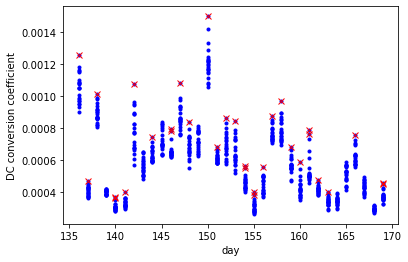

In [35]:
daily_inv_error_df = get_inefficient_inverters_day(daily_inv_error_df, 'MEAN_ERROR', 'alarm_inefficient_inverter_day')
data=daily_inv_error_df
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['MEAN_ERROR'], 'b.')
plt.plot(data[data.alarm_inefficient_inverter_day==1]['DAY'], data[data.alarm_inefficient_inverter_day==1]['MEAN_ERROR'], 'rx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')

In [36]:
daily_inv_error_df[daily_inv_error_df['alarm_inefficient_inverter_day']==1]

,MEAN_ERROR,SOURCE_KEY,DAY,alarm_inefficient_inverter_day
2,0.001257,3PZuoBAID5Wc2HD,136,1
30,0.000468,ZnxXDlPa8U1GXgE,137,1
55,0.001015,bvBOhCH3iADSZry,138,1
90,0.000361,3PZuoBAID5Wc2HD,140,1
94,0.000372,WRmjgnKYAwPKWDb,140,1
120,0.000401,adLQvlD726eNBSB,141,1
143,0.001075,bvBOhCH3iADSZry,142,1
176,0.000743,1BY6WEcLGh8j5v7,144,1
231,0.000795,bvBOhCH3iADSZry,146,1
233,0.000779,ih0vzX44oOqAx2f,146,1


# second plant

In [38]:
weather_data = pd.read_csv('../data/Plant_2_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('../data/Plant_2_Generation_Data.csv')
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'])
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['Time'] = weather_data.DATE_TIME.dt.time
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))
X_t= merged_df.loc[:, ['DC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
scal=MinMaxScaler()
X_test = scal.fit_transform(X_t)
X_test

array([[0.        , 0.33238088, 0.10341988, 0.        ],
       [0.        , 0.33238088, 0.10341988, 0.        ],
       [0.        , 0.33238088, 0.10341988, 0.        ],
       ...,
       [0.        , 0.12393522, 0.04897011, 0.        ],
       [0.        , 0.12393522, 0.04897011, 0.        ],
       [0.        , 0.12393522, 0.04897011, 0.        ]])

In [39]:
encoded_test_data=autoencoder.predict(X_test)
decoded_test_data=autoencoder.predict(encoded_test_data)

In [40]:
X_test_df=pd.DataFrame(X_test, index=X_t.index, columns=X_t.columns)
scaled_test_features = pd.DataFrame(encoded_test_data, index=X_t.index, columns=X_t.columns)
test_mae_loss = np.mean((X_test_df - scaled_test_features)**2, axis=1)
test_mae_loss

0        0.000190
1        0.000190
2        0.000190
3        0.000190
4        0.000190
           ...   
67693    0.000083
67694    0.000083
67695    0.000083
67696    0.000083
67697    0.000083
Length: 67698, dtype: float64

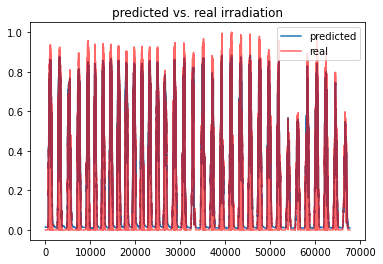

In [41]:
# plt.figure(figsize=(15, 10))
plt.plot(scaled_test_features.DC_POWER, label='predicted')
plt.plot(X_test_df.DC_POWER, label='real', color='r', alpha=0.6)
plt.title('predicted vs. real irradiation')
plt.legend()
plt.show()

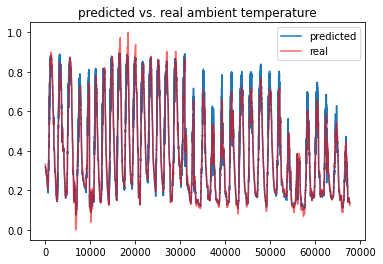

In [42]:
# plt.figure(figsize=(15, 10))
plt.plot(scaled_test_features.AMBIENT_TEMPERATURE, label='predicted')
plt.plot(X_test_df.AMBIENT_TEMPERATURE, label='real', color='r', alpha=0.6)
plt.title('predicted vs. real ambient temperature')
plt.legend()
plt.show()

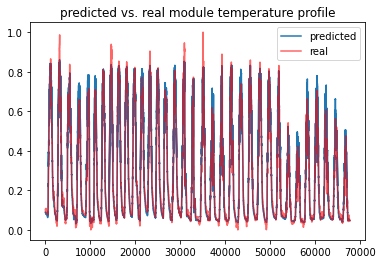

In [43]:
# plt.figure(figsize=(15, 10))
plt.plot(scaled_test_features.MODULE_TEMPERATURE, label='predicted')
plt.plot(X_test_df.MODULE_TEMPERATURE, label='real', color='r', alpha=0.6)
plt.title('predicted vs. real module temperature profile')
plt.legend()
plt.show()

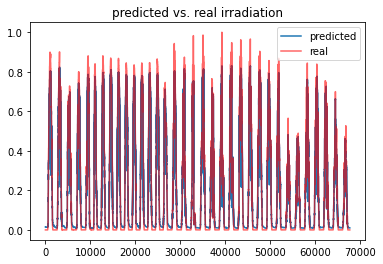

In [44]:
# plt.figure(figsize=(15, 10))
plt.plot(scaled_test_features.IRRADIATION, label='predicted')
plt.plot(X_test_df.IRRADIATION, label='real', color='r', alpha=0.6)
plt.title('predicted vs. real irradiation')
plt.legend()
plt.show()

In [45]:
merged_err=merged_df.join(pd.DataFrame(test_mae_loss))
merged_err.rename(columns={0: 'ERROR'}, inplace=True)
# merged_err.head()

In [48]:
merged_outliers=get_outlier_errors(merged_err, 'ERROR', 'SOURCE_KEY', output_column_name="alarm_DC_conversion", outlier_limit=5, window='7d')
merged_dc_outlier=get_outliers_for_fit(merged_outliers.copy(), 'IRRADIATION', 'DC_POWER', 'SOURCE_KEY', output_column_name="alarm_DC_conversion_outlier_targ", window='7d', outlier_limit=4)

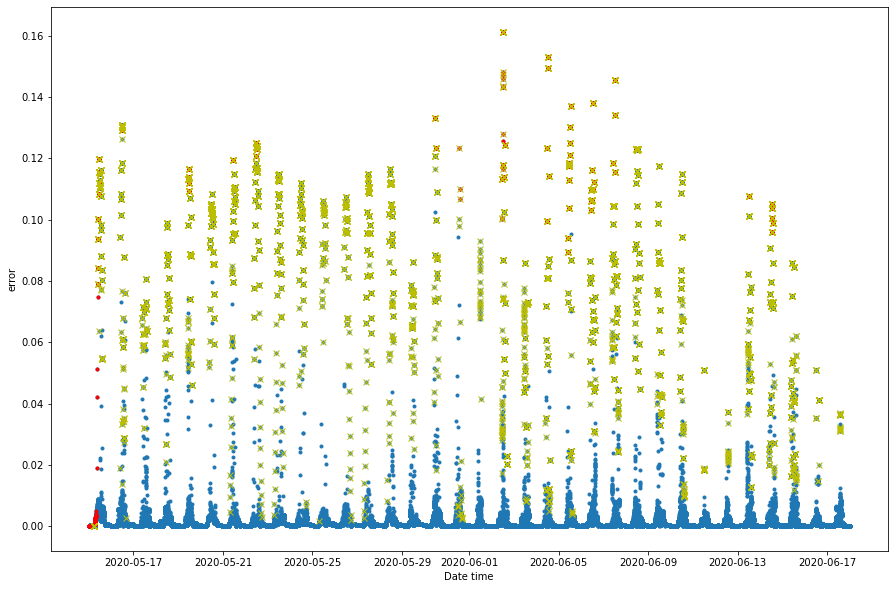

In [50]:
plt.figure(figsize=(15, 10))
plt.plot(merged_dc_outlier['DATE_TIME'], merged_dc_outlier['ERROR'], '.')
plt.plot(merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion"]==1]['DATE_TIME'], 
         merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion"]==1]['ERROR'], 'r.')
plt.plot(merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier_targ"]==1]['DATE_TIME'], 
          merged_dc_outlier[merged_dc_outlier["alarm_DC_conversion_outlier_targ"]==1]['ERROR'], 'yx')
# plt.plot(merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['DATE_TIME'], 
#          merged_ac_conv_out[merged_ac_conv_out["alarm_AC_conversion_outlier"]==1]['ERROR'], 'gx')
plt.xlabel('Date time')
plt.ylabel('error')
plt.show()

In [55]:
print(merged_outliers[merged_outliers.alarm_DC_conversion == 1].shape)
clean_data=merged_outliers.copy()
print(clean_data.shape)
clean_data.drop(clean_data.loc[clean_data.alarm_DC_conversion == 1].index, inplace=True)
print(clean_data.shape)  

(613, 19)
(67698, 19)
(67085, 19)


In [56]:
inv_error_df=inverter_error(clean_data)
# inv_error_df.head()

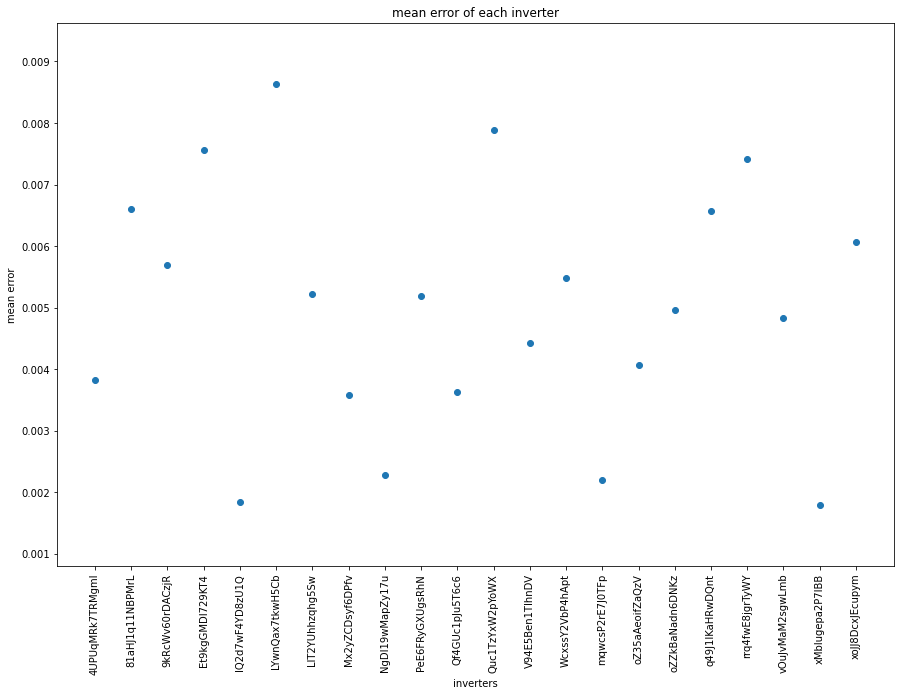

In [57]:
plt.figure(figsize=(15, 10))
plt.scatter(inv_error_df.SOURCE_KEY,inv_error_df.MEAN_ERROR)
plt.xticks(rotation=90) 
plt.ylim(inv_error_df.MEAN_ERROR.min()-0.001,inv_error_df.MEAN_ERROR.max()+0.001)
plt.xlabel('inverters')
plt.ylabel('mean error')
plt.title('mean error of each inverter')
plt.show()

In [58]:
daily_inv_error_df=daily_inverter_error(clean_data)
# daily_inv_error_df

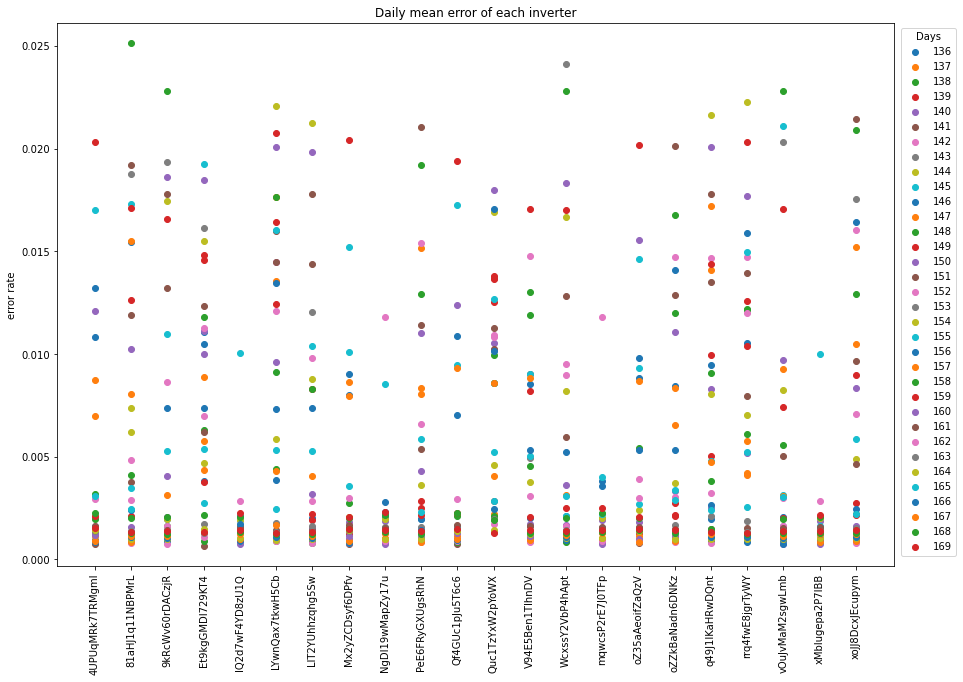

In [59]:
plt.figure(figsize=(15, 10))
for i, day in daily_inv_error_df.groupby(daily_inv_error_df.DAY):
    plt.scatter(day.SOURCE_KEY, day.MEAN_ERROR, label=i)
plt.xticks(rotation=90)
plt.ylim(daily_inv_error_df.MEAN_ERROR.min()-0.001,daily_inv_error_df.MEAN_ERROR.max()+0.001)
plt.ylabel('error rate')
plt.legend(loc="upper right", title="Days", bbox_to_anchor=(1.08, 1))
plt.title('Daily mean error of each inverter')
plt.show()

Text(0, 0.5, 'DC conversion coefficient')

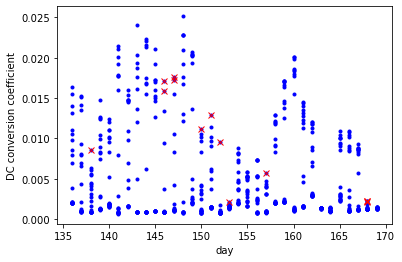

In [60]:


daily_inv_error_df = get_inefficient_inverters_day(daily_inv_error_df, 'MEAN_ERROR', 'alarm_inefficient_inverter_day')
data=daily_inv_error_df
for inv in data.SOURCE_KEY.unique():
    plt.plot(data[data.SOURCE_KEY==inv]['DAY'], data[data.SOURCE_KEY==inv]['MEAN_ERROR'], 'b.')
plt.plot(data[data.alarm_inefficient_inverter_day==1]['DAY'], data[data.alarm_inefficient_inverter_day==1]['MEAN_ERROR'], 'rx')
plt.xlabel('day')
plt.ylabel('DC conversion coefficient')


In [61]:

daily_inv_error_df[daily_inv_error_df['alarm_inefficient_inverter_day']==1]

,MEAN_ERROR,SOURCE_KEY,DAY,alarm_inefficient_inverter_day
55,0.008604,Quc1TzYxW2pYoWX,138,1
213,0.017057,Quc1TzYxW2pYoWX,146,1
219,0.015912,rrq4fwE8jgrTyWY,146,1
226,0.017638,LYwnQax7tkwH5Cb,147,1
236,0.017200,q49J1IKaHRwDQnt,147,1
279,0.011143,Et9kgGMDl729KT4,150,1
314,0.012863,oZZkBaNadn6DNKz,151,1
333,0.009509,WcxssY2VbP4hApt,152,1
359,0.002104,q49J1IKaHRwDQnt,153,1
433,0.005769,Et9kgGMDl729KT4,157,1
